In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time

In [20]:
path = os.path.abspath("")
obj = 'koala'
filePath = f'{path}\\..\\{obj}\\{obj}'
inter = cv2.imread(f'{filePath}.jpg')
img = np.asarray(cv2.cvtColor(inter, cv2.COLOR_RGB2GRAY), np.float64)

In [21]:
def fourier_denoise(image):
    f_transform = np.fft.fft2(image)
    center_shift = np.fft.fftshift(f_transform)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    center_shift[crow - 4:crow + 4, 0:ccol - 10] = 1
    center_shift[crow - 4:crow + 4, ccol + 10:] = 1

    f_shift = np.fft.ifftshift(center_shift)
    return np.abs(np.fft.ifft2(f_shift))

In [22]:
def plot_images():
    noised = img
    denoised = fourier_denoise(noised)

    rmse1 = np.sqrt(np.mean((noised - denoised) ** 2))

    images = [
        noised, denoised, cv2.absdiff(noised, denoised)
    ]
    image_titles = [
        'Noised RGB image',
        'Denoised RGB image',
        f'Difference between noised and denoised RGB images\n RMSE: {rmse1:.3f}'
    ]

    num_rows = 1
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()

    for i, (image, title) in enumerate(zip(images, image_titles)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(title, fontsize=12)  # Set the title
        axes[i].axis('off')  # Hide axes ticks and labels

    # If there are empty subplots, turn off the axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    # Show the plot
    plt.tight_layout()
    #plt.savefig(f'{filePath}-comparison-plot.png', format='png', dpi=600)
    plt.show()

In [23]:
def plot_performance():
    times = []

    for x in range(100):

        start = time.time()

        fourier_denoise(img)

        times.append(time.time() - start)

    mean = np.mean(times)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(range(100), times, marker='o', label = "Iterations execution time")
    plt.plot(range(100), [mean for x in range(100)], marker='o', label = "Mean execution time")
    plt.title('Landscape Denoising Execution Time')
    plt.xlabel('Iteration')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    #plt.savefig(f'{filePath}-performance-plot.png', format='png', dpi=600)
    plt.show()

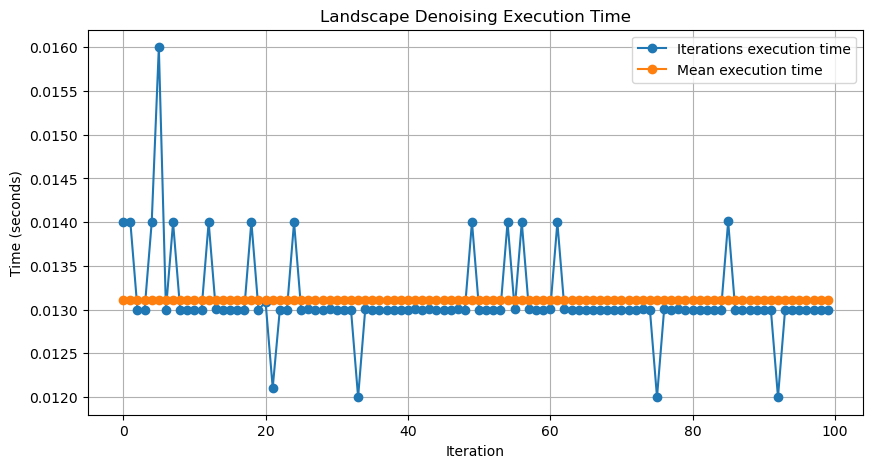

In [24]:
plot_performance()

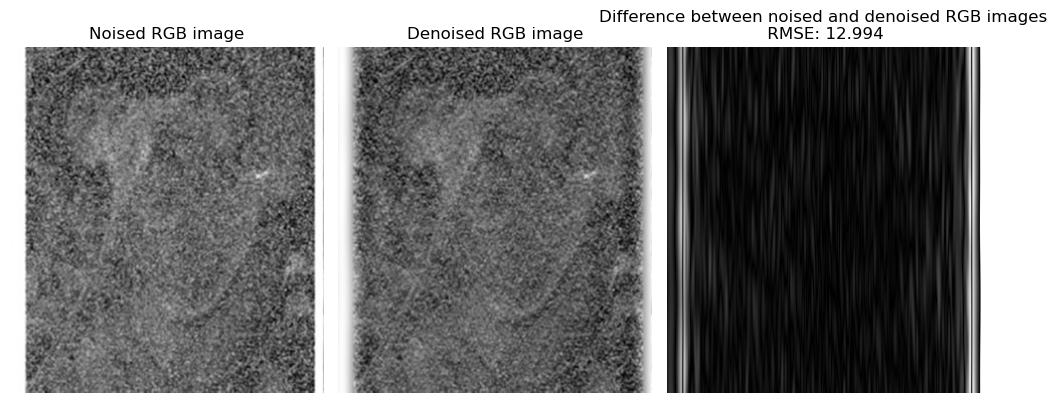

In [25]:
plot_images()